In [0]:

!pip install -Uq watermark

In [40]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch

CPython 3.6.9
IPython 5.5.0

numpy 1.18.3
pandas 1.0.3
torch 1.5.0+cu101


In [41]:
from google.colab import files 
 
import io
 
uploaded = files.upload()


import torch

import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

COLORS = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

sns.set_palette(sns.color_palette(COLORS))

rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

Saving ee11.csv to ee11 (1).csv


In [42]:

df = pd.read_csv(io.StringIO(uploaded['ee11.csv'].decode('utf-8')))

df = df.iloc[:, 4:]

df.head()



,2015-05-01,2015-06-01,2015-07-01,2015-08-01,2015-09-01,2015-10-01,2015-11-01,2015-12-01,2016-01-01,2016-02-01,2016-03-01,2016-04-01,2016-05-01,2016-06-01,2016-07-01,2016-08-01,2016-09-01,2016-10-01,2016-11-01,2016-12-01,2017-01-01,2017-02-01,2017-03-01,2017-04-01,2017-05-01,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01,2018-07-01,2018-08-01,2018-09-01,2018-10-01,2018-11-01,2018-12-01,2019-01-01,2019-02-01,2019-03-01,2019-04-01,2019-05-01,2019-06-01,2019-07-01,2019-08-01,2019-09-01,2019-10-01,2019-11-01,2019-12-01,2020-01-01,2020-02-01,2020-03-01,2020-04-01,2020-05-01
0,1.63708,4.08676,4.64104,2.84207,3.00978,3.80433,3.62122,3.48017,3.05216,3.44611,3.25707,3.65975,4.65039,4.1935,4.01382,3.79744,3.8416,3.99396,3.89379,4.32529,4.07864,3.77099,6.66706,15.7056,25.2976,40.354301,43.022701,71.055099,55.142399,55.754101,88.330704,232.095993,163.350998,202.895004,116.607002,148.477005,118.073997,81.374001,79.702301,61.925499,61.141899,49.441502,32.064762,30.468224,31.652176,46.237259,60.755398,74.280876,114.536957,122.249115,98.509575,64.57605,56.056908,58.780685,47.47543,41.340073,67.879494,58.543262,39.299103,49.181301,47.568943


In [43]:
df.isnull().sum().sum()

0

In [0]:
daily_cases = df.sum(axis=0)
daily_cases.index = pd.to_datetime(daily_cases.index)


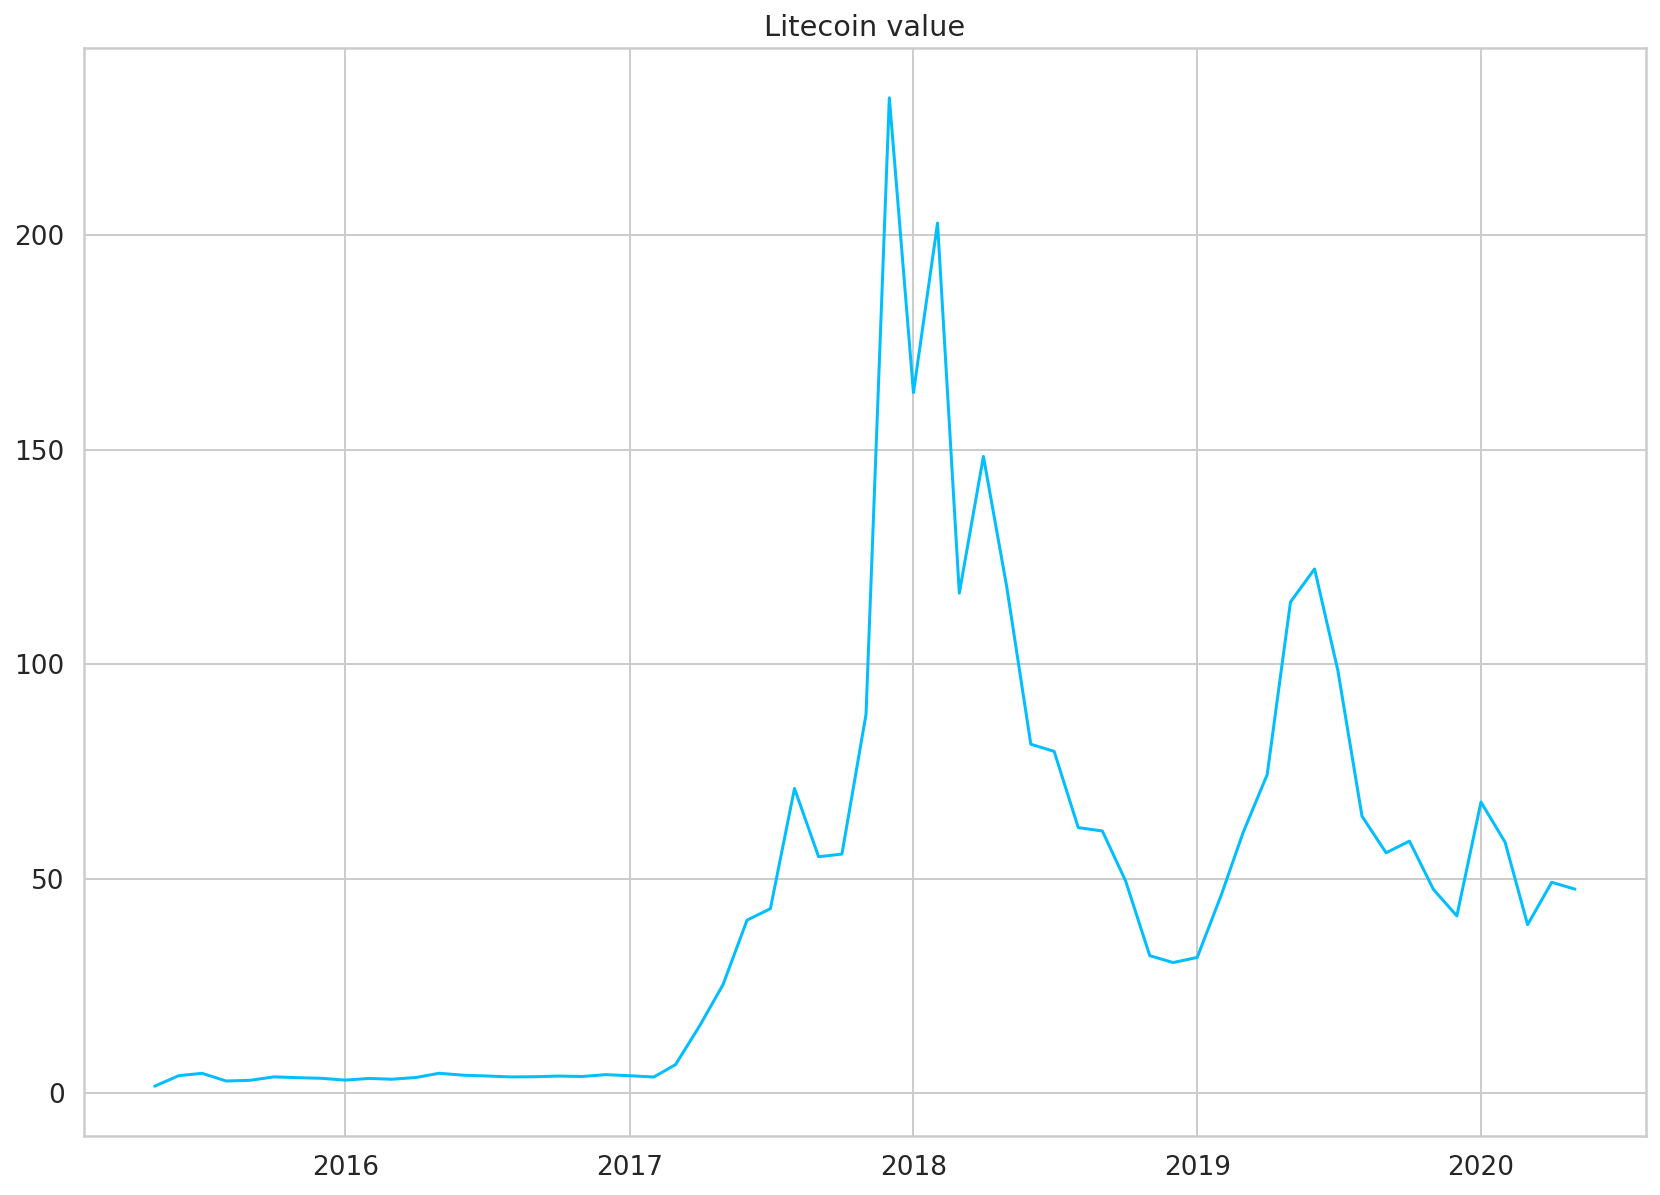

In [45]:
plt.plot(daily_cases)
plt.title("Litecoin value");

In [46]:
daily_cases.shape

(61,)

In [47]:
test_data_size = 50

train_data = daily_cases[:-test_data_size]
test_data = daily_cases[-test_data_size:]

train_data.shape

(11,)

In [0]:
scaler = MinMaxScaler()

scaler = scaler.fit(np.expand_dims(train_data, axis=1))

train_data = scaler.transform(np.expand_dims(train_data, axis=1))

test_data = scaler.transform(np.expand_dims(test_data, axis=1))

In [0]:
def create_sequences(data, seq_length):
    xs = []
    ys = []

    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

In [0]:
seq_length = 5
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

In [51]:
X_train.shape

torch.Size([5, 5, 1])

In [52]:
X_train[:2]

tensor([[[0.0000],
         [0.8155],
         [1.0000],
         [0.4011],
         [0.4570]],

        [[0.8155],
         [1.0000],
         [0.4011],
         [0.4570],
         [0.7215]]])

In [53]:
y_train.shape

torch.Size([5, 1])

In [54]:
y_train[:2]

tensor([[0.7215],
        [0.6605]])

In [55]:
train_data[:10]

array([[0.        ],
       [0.81548356],
       [1.        ],
       [0.40113384],
       [0.45696347],
       [0.72146433],
       [0.66050813],
       [0.61355344],
       [0.47107152],
       [0.60221508]])

In [0]:
class CoronaVirusPredictor(nn.Module):

  def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
    super(CoronaVirusPredictor, self).__init__()

    self.n_hidden = n_hidden
    self.seq_len = seq_len
    self.n_layers = n_layers

    self.lstm = nn.LSTM(
      input_size=n_features,
      hidden_size=n_hidden,
      num_layers=n_layers,
      dropout=0.5
    )

    self.linear = nn.Linear(in_features=n_hidden, out_features=1)

  def reset_hidden_state(self):
    self.hidden = (
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
    )

  def forward(self, sequences):
    lstm_out, self.hidden = self.lstm(
      sequences.view(len(sequences), self.seq_len, -1),
      self.hidden
    )
    last_time_step = \
      lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
    y_pred = self.linear(last_time_step)
    return y_pred

In [0]:
def train_model(
  model, 
  train_data, 
  train_labels, 
  test_data=None, 
  test_labels=None
):
  loss_fn = torch.nn.MSELoss(reduction='sum')

  optimiser = torch.optim.Adam(model.parameters(), lr=1e-3)
  num_epochs = 60

  train_hist = np.zeros(num_epochs)
  test_hist = np.zeros(num_epochs)

  for t in range(num_epochs):
    model.reset_hidden_state()

    y_pred = model(X_train)

    loss = loss_fn(y_pred.float(), y_train)

    if test_data is not None:
      with torch.no_grad():
        y_test_pred = model(X_test)
        test_loss = loss_fn(y_test_pred.float(), y_test)
      test_hist[t] = test_loss.item()

      if t % 10 == 0:  
        print(f'Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}')
    elif t % 10 == 0:
      print(f'Epoch {t} train loss: {loss.item()}')

    train_hist[t] = loss.item()
    
    optimiser.zero_grad()

    loss.backward()

    optimiser.step()
  
  return model.eval(), train_hist, test_hist

In [58]:
model = CoronaVirusPredictor(
  n_features=1, 
  n_hidden=512, 
  seq_len=seq_length, 
  n_layers=2
)
model, train_hist, test_hist = train_model(
  model, 
  X_train, 
  y_train, 
  X_test, 
  y_test
)

Epoch 0 train loss: 1.8163795471191406 test loss: 31946.67578125
Epoch 10 train loss: 0.1788177341222763 test loss: 29627.21875
Epoch 20 train loss: 0.02550828643143177 test loss: 28259.263671875
Epoch 30 train loss: 0.05123841017484665 test loss: 28116.390625
Epoch 40 train loss: 0.028873400762677193 test loss: 28813.740234375
Epoch 50 train loss: 0.03284667059779167 test loss: 28798.439453125


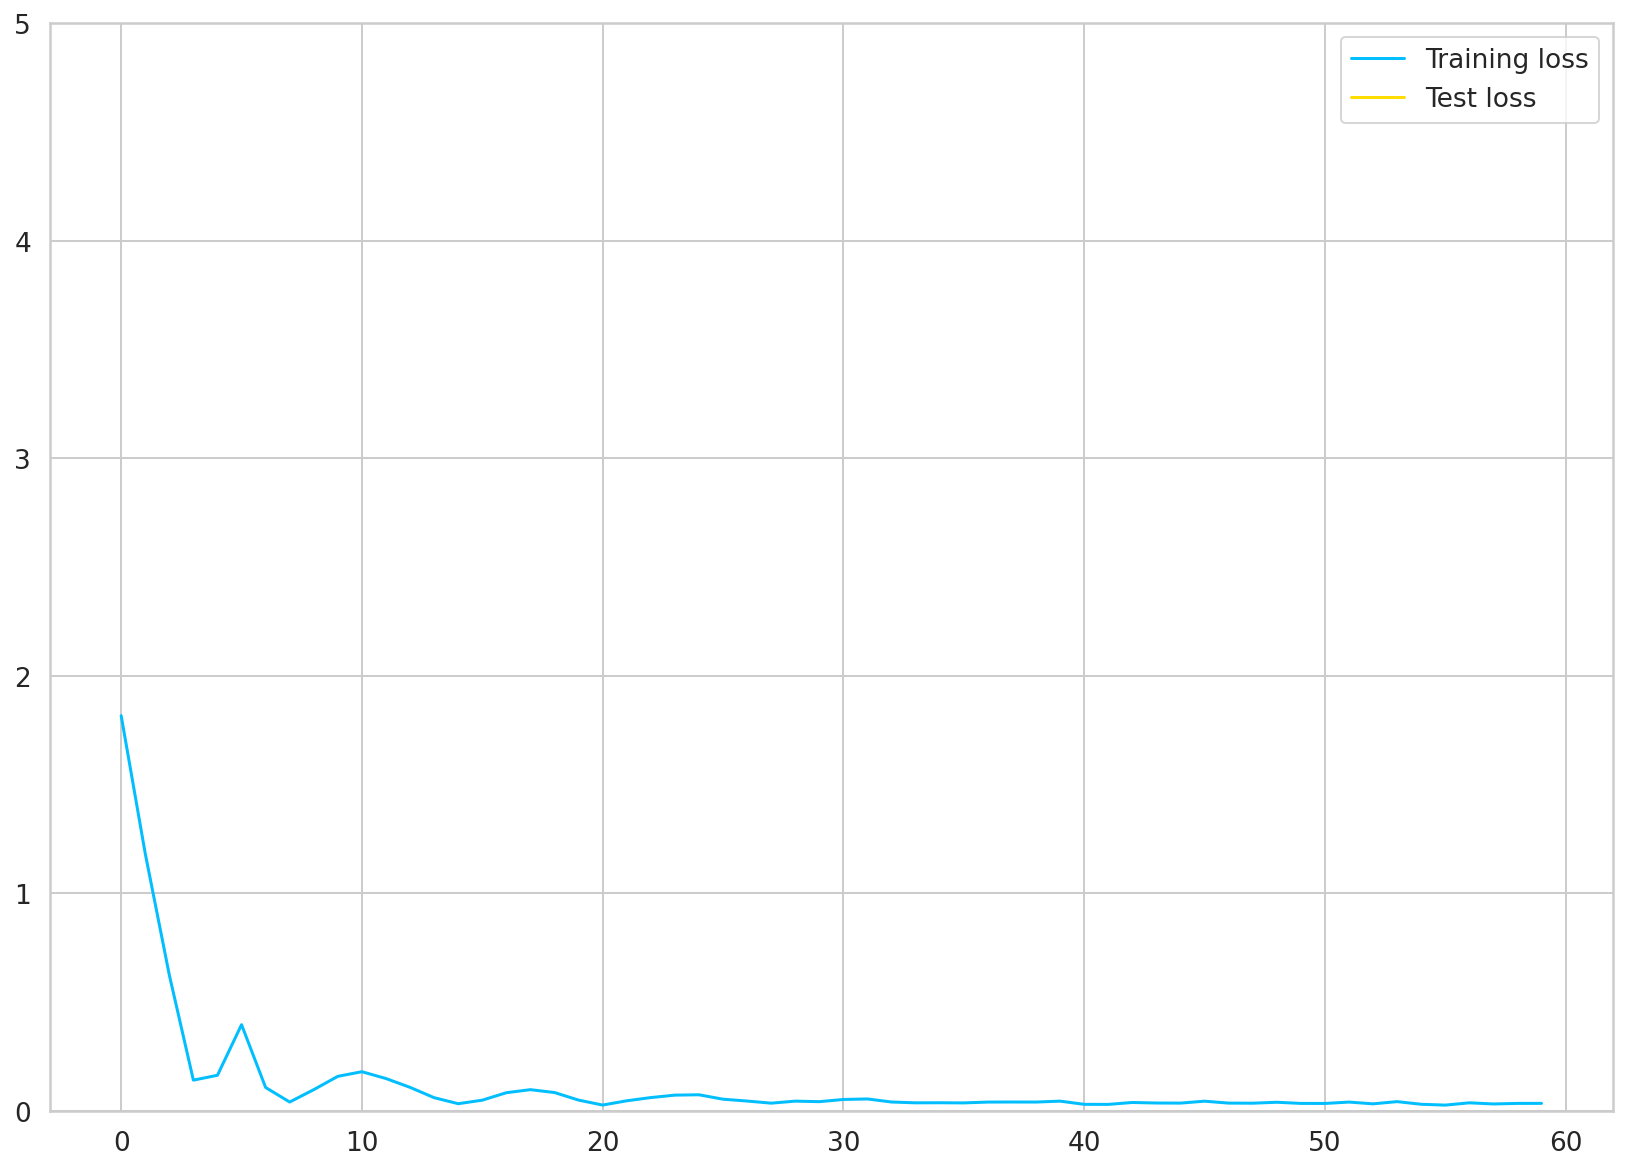

In [59]:
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
plt.ylim((0, 5))
plt.legend();

In [0]:
with torch.no_grad():
  test_seq = X_test[:1]
  preds = []
  for _ in range(len(X_test)):
    y_test_pred = model(test_seq)
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)
    new_seq = test_seq.numpy().flatten()
    new_seq = np.append(new_seq, [pred])
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

In [0]:
true_cases = scaler.inverse_transform(
    np.expand_dims(y_test.flatten().numpy(), axis=0)
).flatten()

predicted_cases = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()

In [62]:
scaler = MinMaxScaler()

scaler = scaler.fit(np.expand_dims(daily_cases, axis=1))

all_data = scaler.transform(np.expand_dims(daily_cases, axis=1))

all_data.shape

(61, 1)

In [63]:
X_all, y_all = create_sequences(all_data, seq_length)

X_all = torch.from_numpy(X_all).float()
y_all = torch.from_numpy(y_all).float()

model = CoronaVirusPredictor(
  n_features=1, 
  n_hidden=512, 
  seq_len=seq_length, 
  n_layers=2
)
model, train_hist, _ = train_model(model, X_all, y_all)

Epoch 0 train loss: 2.032876968383789
Epoch 10 train loss: 0.1918490082025528
Epoch 20 train loss: 0.030504273250699043
Epoch 30 train loss: 0.04701866954565048
Epoch 40 train loss: 0.03624774143099785
Epoch 50 train loss: 0.039624568074941635


In [0]:
DAYS_TO_PREDICT = 200

with torch.no_grad():
  test_seq = X_all[:1]
  preds = []
  for _ in range(DAYS_TO_PREDICT):
    y_test_pred = model(test_seq)
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)
    new_seq = test_seq.numpy().flatten()
    new_seq = np.append(new_seq, [pred])
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

In [0]:
predicted_cases = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()

In [68]:
daily_cases.index[-1]

Timestamp('2020-05-01 00:00:00')

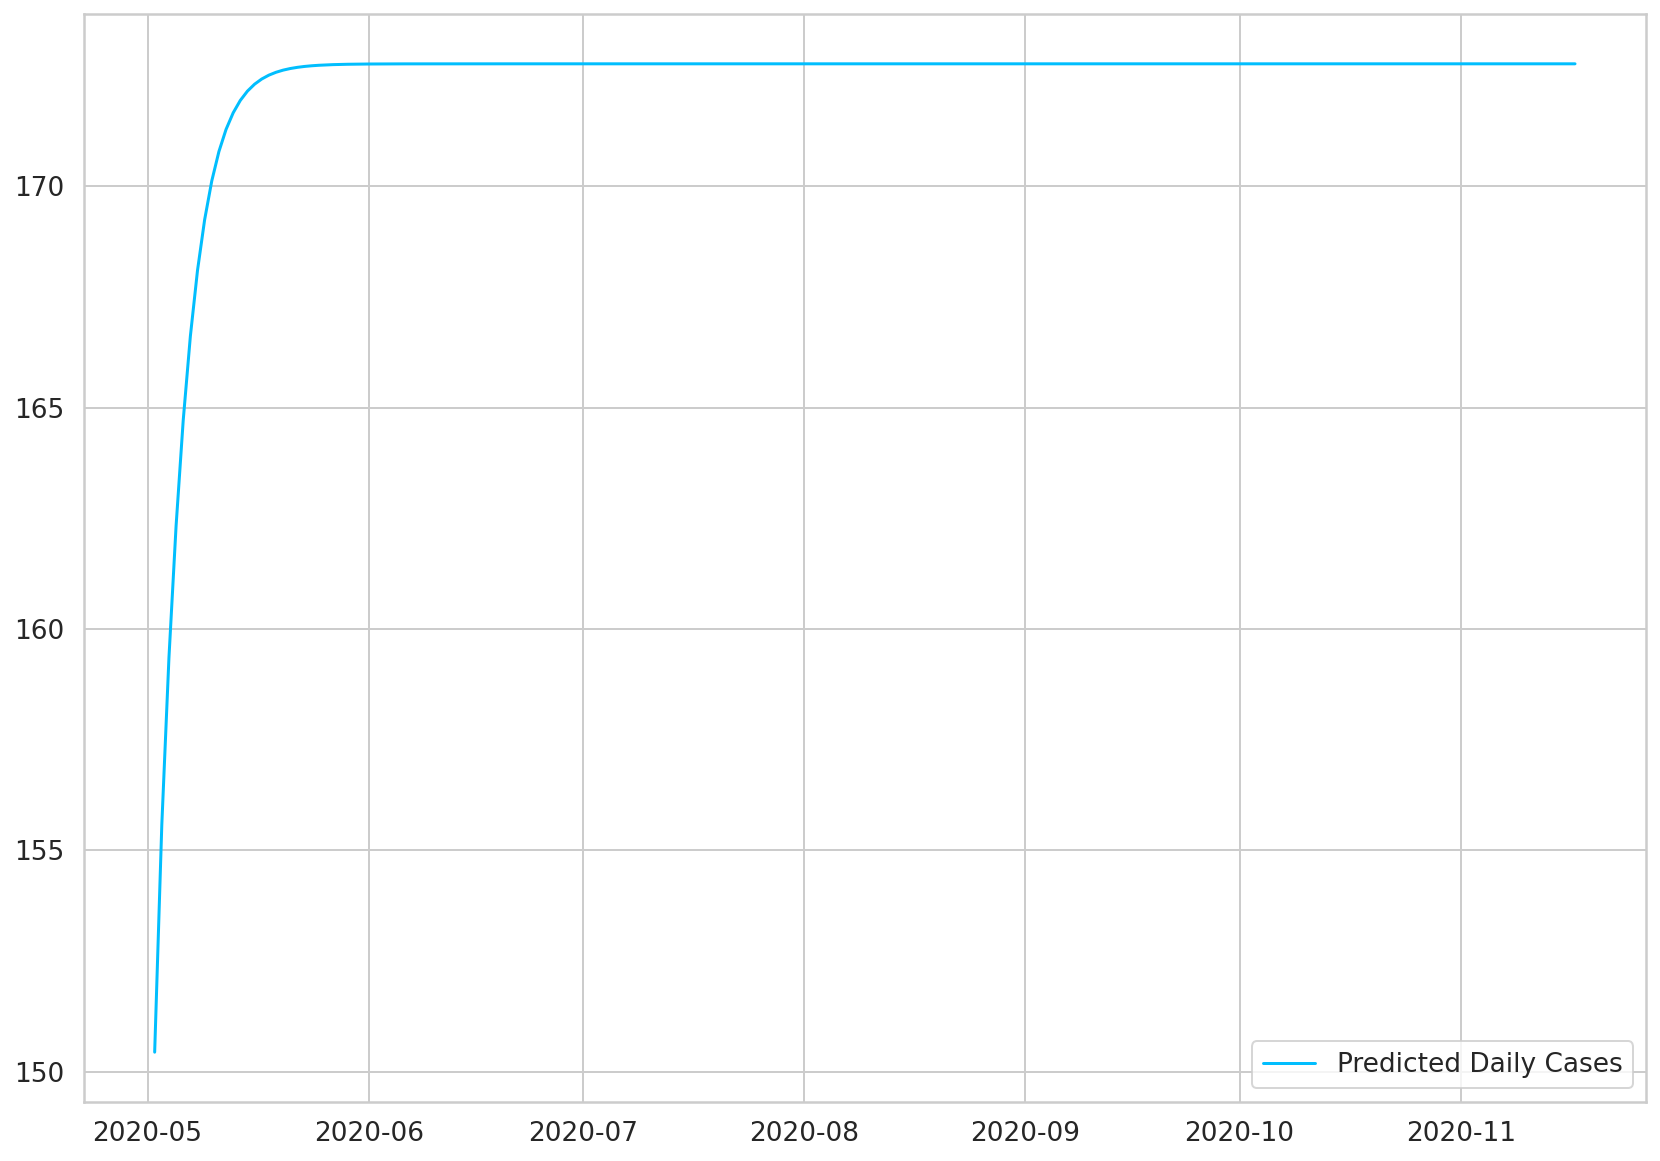

In [69]:
predicted_index = pd.date_range(
  start=daily_cases.index[-1],
  periods=DAYS_TO_PREDICT + 1,
  closed='right'
)

predicted_cases = pd.Series(
  data=predicted_cases,
  index=predicted_index
)

plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.legend();

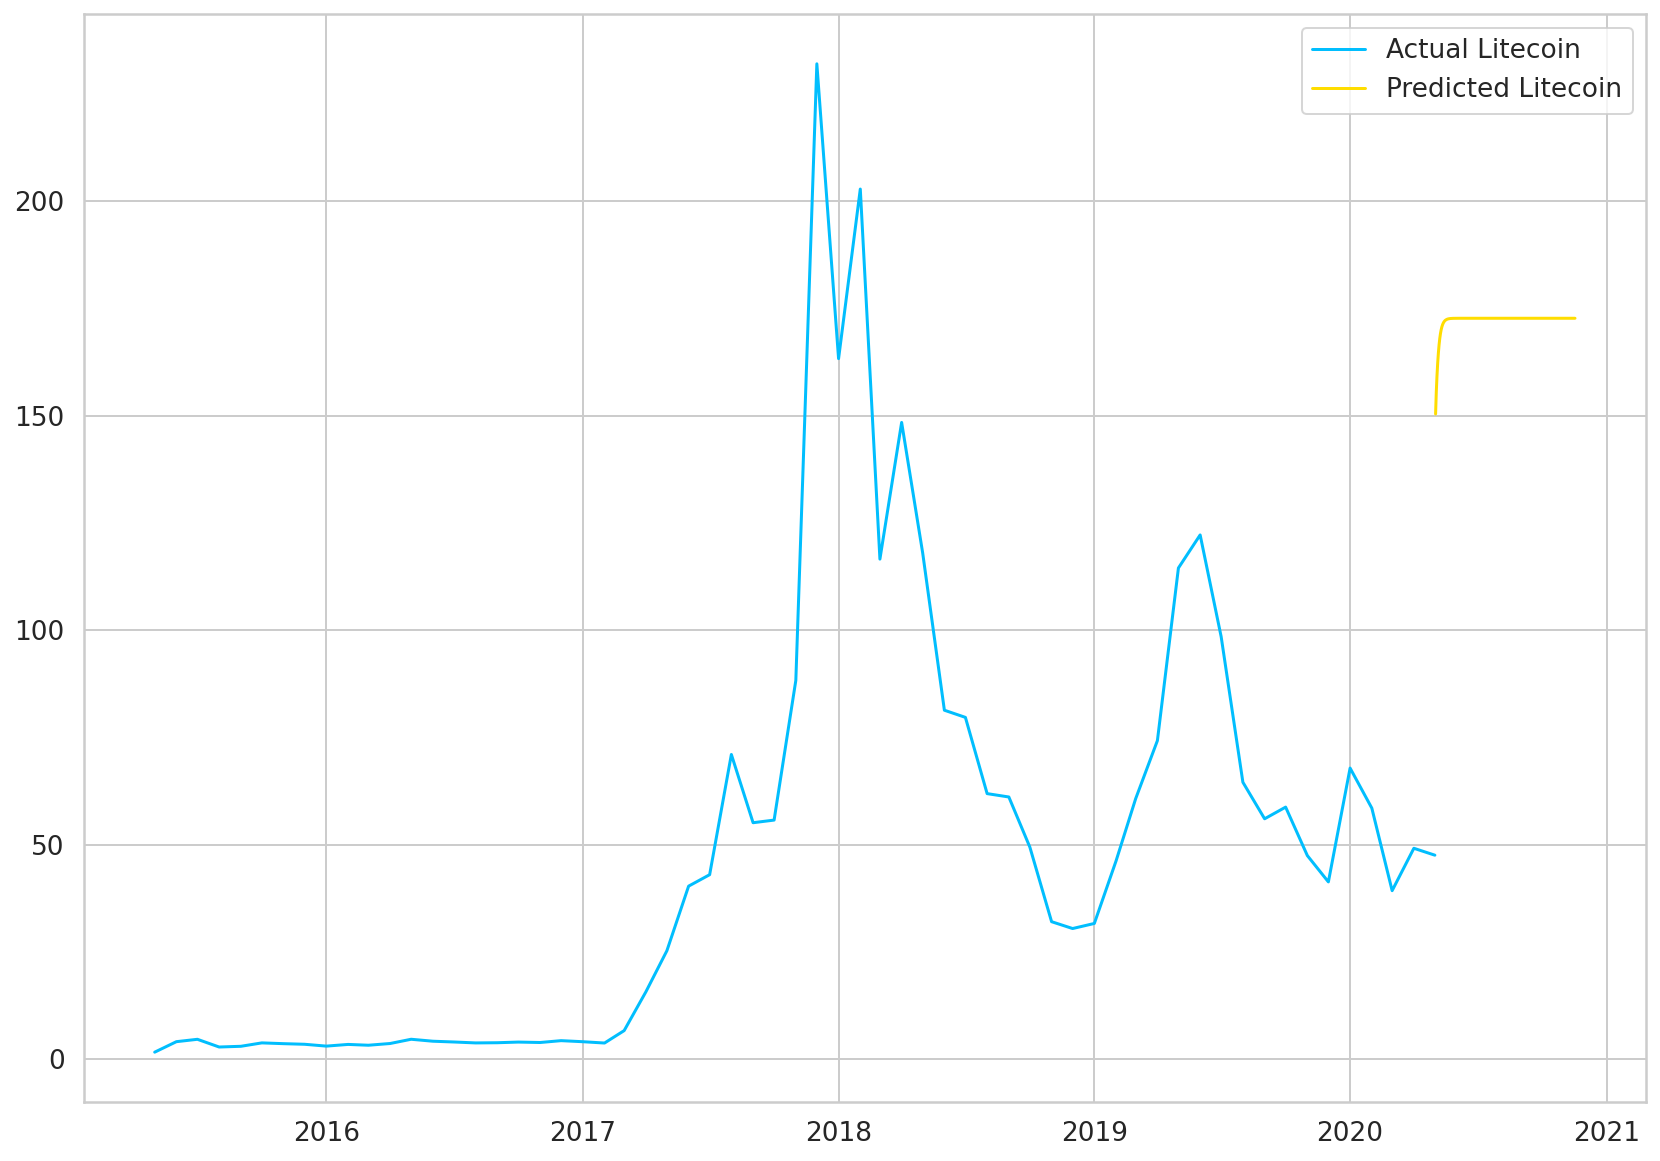

In [70]:
plt.plot(daily_cases, label='Actual Litecoin')
plt.plot(predicted_cases, label='Predicted Litecoin')
plt.legend();